# Evaluation of different classification algorithms for COVID-19 Pandemic Tweets

#### Stylianos Sidiropoulos (stysi607)

#### Text Mining (732A92) - Linköping University

In [1]:
# Import libraries
import pandas as pd
#import numpy as np
import spacy
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

## Data Preprocessing

keep only useful columns, check for nulls, check if dataset is balanced, balance dataset, lowercase words, remove stopwords, punctuations, numbers, links, hashtags, mentions etc.

Dataset: https://www.kaggle.com/datatattle/covid-19-nlp-text-classification

In [26]:
# Read data and merge it into one dataset
data = pd.read_csv("data.csv", encoding="latin")

whole_dataset=True

if not whole_dataset:
    data = data.loc[:1000]
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [27]:
# Keep only OriginalTweet and Sentiment columns
data.pop("UserName")
data.pop("ScreenName")
data.pop("Location")
data.pop("TweetAt")
data.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [28]:
# Check if there are null values
data.isnull().values.any()

False

In [29]:
data.shape

(44955, 2)

In [7]:
sentiments = data.Sentiment.unique().tolist()
sentiments

['Neutral', 'Positive', 'Extremely Negative', 'Negative', 'Extremely Positive']

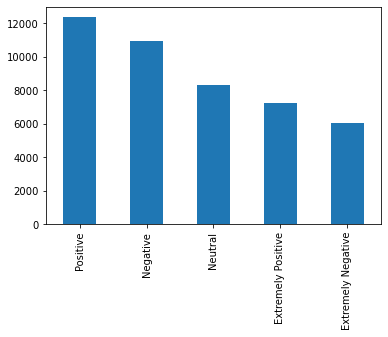

In [8]:
data.Sentiment.value_counts().plot(kind='bar');

Dataset is not balanced. (should I balance it?)

In [38]:
# Balance dataset
count_ExNeg = data.Sentiment.value_counts().min()

# Divide by class and Random undersampling without replacement
df_Pos = data[data.Sentiment == "Positive"].sample(count_ExNeg)
df_Neg = data[data.Sentiment == "Negative"].sample(count_ExNeg)
df_Neu = data[data.Sentiment == "Neutral"].sample(count_ExNeg)
df_ExPos = data[data.Sentiment == "Extremely Positive"].sample(count_ExNeg)
df_ExNeg = data[data.Sentiment == "Extremely Negative"]

data_balanced = pd.concat([df_Pos, df_Neg, df_Neu, df_ExPos, df_ExNeg], axis=0)

In [41]:
data_balanced.Sentiment.value_counts()

Positive              6073
Extremely Positive    6073
Negative              6073
Neutral               6073
Extremely Negative    6073
Name: Sentiment, dtype: int64

In [30]:
# Natural Language Processing (NLP)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner'])

def preprocess(text):
    doc = nlp(text)
    return [token.lemma_.lower() for token in doc if not token.is_stop and token.lemma_.isalpha() and len(token)>2]

In [42]:
data_balanced["ProcessedTweet"] = data_balanced["OriginalTweet"].apply(lambda x: ' '.join(preprocess(x)))

data["ProcessedTweet"] = data["OriginalTweet"].apply(lambda x: ' '.join(preprocess(x)))
data.head()

,OriginalTweet,Sentiment,ProcessedTweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,advice Talk to your neighbours family to excha...,Positive,advice talk neighbour family exchange phone nu...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths elderly disab...
3,My food stock is not the only one which is emp...,Positive,food stock panic food need stay calm stay safe...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready supermarket outbreak paranoid food stock...


## Statistics

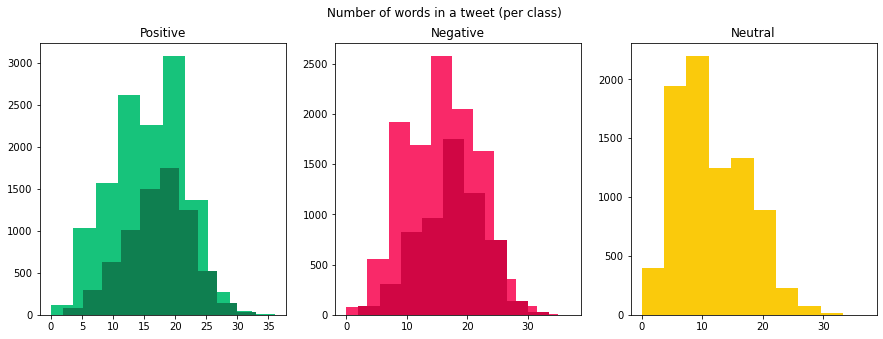

In [55]:
fig1,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

len_pos = data[data['Sentiment']=="Positive"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax1.hist(len_pos, color='#17C37B')
ax1.set_title('Positive')

len_neg = data[data['Sentiment']=="Negative"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax2.hist(len_neg, color='#F92969')
ax2.set_title('Negative')

len_neu = data[data['Sentiment']=="Neutral"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax3.hist(len_neu, color='#FACA0C')
ax3.set_title('Neutral')

len_expos = data[data['Sentiment']=="Extremely Positive"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax1.hist(len_expos, color='#0f7f50')

len_exneg = data[data['Sentiment']=="Extremely Negative"]['ProcessedTweet'].str.split().map(lambda x: len(x))
ax2.hist(len_exneg, color='#d00644')

fig1.suptitle('Number of words in a tweet (per class)')
plt.show()

In [111]:
def create_wordlist(sentiment):
    wordlist=[]
    words_removed = ["coronavirus", "coronaviru", "covid19", "covid-19", "covid", "amp"]
    for line in data[data["Sentiment"]==sentiment]["ProcessedTweet"].str.split():
        for word in line:
            if word not in words_removed:
                wordlist.append(word)
    return wordlist

def create_wordcloud(sentiment):
    wordcloud = WordCloud().generate(" ".join(words for words in create_wordlist(sentiment)))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(sentiment + " " + "wordcloud")
    plt.show()

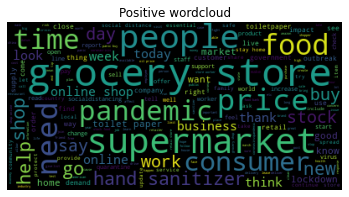

In [112]:
create_wordcloud("Positive")

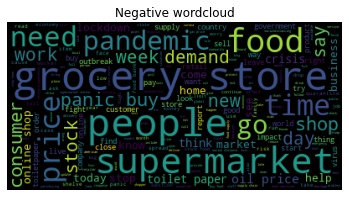

In [113]:
create_wordcloud("Negative")

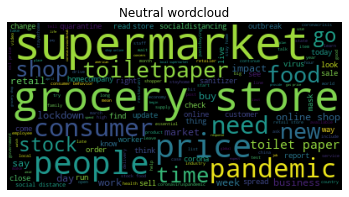

In [114]:
create_wordcloud("Neutral")

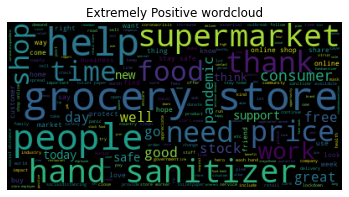

In [115]:
create_wordcloud("Extremely Positive")

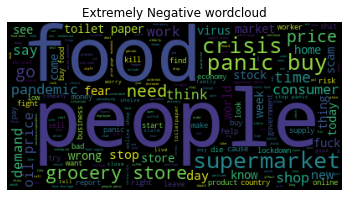

In [116]:
create_wordcloud("Extremely Negative")

In [127]:
def most_common_ngrams(sentiment, n_gram=1, n_common=10):
    wordlist = create_wordlist(sentiment)
    ngrams = zip(*[wordlist[i:] for i in range(n_gram)])
    counter = Counter(' '.join(ngram) for ngram in ngrams)
    return counter.most_common(n_common)

In [134]:
most_common_ngrams("Positive", n_gram=2)

[('grocery store', 1709),
 ('hand sanitizer', 722),
 ('online shop', 454),
 ('toilet paper', 403),
 ('stay home', 219),
 ('social distance', 215),
 ('oil price', 177),
 ('stock food', 175),
 ('panic buy', 169),
 ('store worker', 166)]

In [135]:
most_common_ngrams("Negative", n_gram=2)

[('grocery store', 1381),
 ('panic buy', 572),
 ('oil price', 415),
 ('toilet paper', 411),
 ('online shop', 352),
 ('food bank', 194),
 ('stock food', 170),
 ('social distance', 163),
 ('stay home', 157),
 ('supermarket shelve', 155)]

In [136]:
most_common_ngrams("Neutral", n_gram=2)

[('grocery store', 1077),
 ('toilet paper', 316),
 ('online shop', 304),
 ('social distance', 130),
 ('retail store', 116),
 ('consumer behavior', 115),
 ('oil price', 111),
 ('stock food', 105),
 ('stay home', 89),
 ('shop online', 80)]

In [137]:
most_common_ngrams("Extremely Positive", n_gram=2)

[('grocery store', 1031),
 ('hand sanitizer', 773),
 ('online shop', 279),
 ('stay safe', 212),
 ('toilet paper', 197),
 ('stay home', 158),
 ('store worker', 148),
 ('shop online', 139),
 ('social distance', 130),
 ('wash hand', 127)]

In [138]:
most_common_ngrams("Extremely Negative", n_gram=2)

[('panic buy', 694),
 ('grocery store', 620),
 ('oil price', 290),
 ('toilet paper', 240),
 ('buy food', 148),
 ('stop panic', 137),
 ('online shop', 122),
 ('supermarket shelve', 115),
 ('food supply', 114),
 ('supply chain', 110)]

## Models

In [92]:
# Split train, test
X = data.OriginalTweet
y = data.Sentiment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [93]:
# Vectorizers
count_vectorizer = CountVectorizer(tokenizer=preprocess)
tfidf_vectorizer = TfidfVectorizer(tokenizer=preprocess)

In [45]:
# CountVectorizer - Logistic Regression
model = Pipeline([
    ('vectorizer', count_vectorizer),
    ('predictor', LogisticRegression(max_iter=100000))
])

model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

print(classification_report(y_test, y_predicted))

                    precision    recall  f1-score   support

Extremely Negative       0.56      0.34      0.42        82
Extremely Positive       0.48      0.32      0.38        76
          Negative       0.42      0.44      0.43       158
           Neutral       0.39      0.52      0.44        73
          Positive       0.30      0.36      0.32       112

          accuracy                           0.40       501
         macro avg       0.43      0.40      0.40       501
      weighted avg       0.42      0.40      0.40       501



In [46]:
# CountVectorizer - Multinomial Naive Bayes
model = Pipeline([
    ('vectorizer', count_vectorizer),
    ('predictor', MultinomialNB())
])

model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

print(classification_report(y_test, y_predicted))

                    precision    recall  f1-score   support

Extremely Negative       0.45      0.21      0.28        82
Extremely Positive       0.38      0.24      0.29        76
          Negative       0.36      0.46      0.40       158
           Neutral       0.38      0.12      0.19        73
          Positive       0.28      0.48      0.36       112

          accuracy                           0.34       501
         macro avg       0.37      0.30      0.30       501
      weighted avg       0.36      0.34      0.32       501



In [47]:
# CountVectorizer - Random Forest
model = Pipeline([
    ('vectorizer', count_vectorizer),
    ('predictor', RandomForestClassifier())
])

model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

print(classification_report(y_test, y_predicted))

                    precision    recall  f1-score   support

Extremely Negative       0.54      0.18      0.27        82
Extremely Positive       0.56      0.30      0.39        76
          Negative       0.44      0.44      0.44       158
           Neutral       0.35      0.68      0.46        73
          Positive       0.32      0.37      0.34       112

          accuracy                           0.40       501
         macro avg       0.44      0.40      0.38       501
      weighted avg       0.43      0.40      0.39       501



In [48]:
# CountVectorizer - LinearSVC
model = Pipeline([
    ('vectorizer', count_vectorizer),
    ('predictor', LinearSVC())
])

model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

print(classification_report(y_test, y_predicted))

                    precision    recall  f1-score   support

Extremely Negative       0.57      0.37      0.44        82
Extremely Positive       0.49      0.41      0.45        76
          Negative       0.43      0.41      0.42       158
           Neutral       0.34      0.55      0.42        73
          Positive       0.23      0.23      0.23       112

          accuracy                           0.38       501
         macro avg       0.41      0.39      0.39       501
      weighted avg       0.40      0.38      0.38       501

